In [1]:
import sys
sys.path.append("/home/qrr2/project/")
sys.path.append("/home/qrr2/project/QOGS/")
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import h5py as h5
import qutip as qt
from qutip import tensor, basis,qeye,sigmax,sigmay,sigmaz, destroy, create, num, fock
from qutip import *
from importlib import reload
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize, LinearConstraint
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy import signal
from scipy.interpolate import interp1d
from scipy.spatial import distance
import matplotlib.colors
from qutip import Qobj
from scipy.stats import poisson
%matplotlib inline
%load_ext autoreload
%autoreload 2

# RPN Using Truncated Basis + Initial Guess

### Fitting Parameters

In [2]:
h5filename = '20240702_optimal_control.h5'
start_time = '20240710_181413'
end_time = '20240710_185049'
target_fock = 3 # Target fock integer
target_basis = target_fock + 2 # Number of basis states in the fit
amps = np.arange(1.00, 1.05, 0.01) # List of OPX amplitudes scanned
measurement_time = 12 # Actual measurement time in μs
maxtime = 10 # Time in μs that you want to fit
g = 0.284 # In MHz
T1q = 22 # In (*@\textcolor{codegreen}{$\mu$}@*)s
T2q = 20 # In (*@\textcolor{codegreen}{$\mu$}@*)s
T1p = 94.61 # In (*@\textcolor{codegreen}{$\mu$}@*)s

### Function Definitions

In [3]:
def get_datasets_between_timestamps(h5filename, start_time, end_time):
    with h5.File(h5filename, 'r') as f:
        datasets = list(f.keys())
    filtered_datasets = [ds for ds in datasets if start_time <= ds <= end_time]
    return filtered_datasets

def truncate_data(data, max_time=measurement_time):
    mask = data[0] <= max_time
    return np.array([data[0][mask], data[1][mask]])

def read_1D_data(file_name):
    with h5.File(h5filename, 'r') as f:
        dataset = f[file_name]
        return np.array([dataset['xdata'][:], dataset['ydata'][:]])

def fit_qubit_phonon_interaction_normalization(data, measurement_time, g, T1_q, T2_q_pure, T1_p):
    xdata = data[0]
    ydata = data[1]

    def Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, t_list, Fock_num):
        gamma1_q = 1 / T1_q
        gamma2_q = 1 / T2_q_pure
        gamma1_p = 1 / T1_p
        qubit_dim = 2
        phonon_dim = Fock_num + 2
        q_en = tensor(num(qubit_dim), qeye(phonon_dim))
        swap = tensor(destroy(qubit_dim), create(phonon_dim))
        q_ani = tensor(destroy(qubit_dim), qeye(phonon_dim))
        p_ani = tensor(qeye(qubit_dim), destroy(phonon_dim))
        H_JC = 2 * np.pi * (g * swap + g * swap.dag())
        H_tot = H_JC
        c_ops = [np.sqrt(gamma1_q) * q_ani, np.sqrt(gamma2_q) * q_en, np.sqrt(gamma1_p) * p_ani]
        initial_state = tensor(qt.fock(qubit_dim, 1), qt.fock(phonon_dim, Fock_num))
        result = qt.mesolve(H_tot, initial_state, t_list, c_ops, [q_en])
        return result.expect[0]

    truncated_indices = np.where(xdata <= measurement_time)
    time_data = xdata[truncated_indices] + 0.05
    ydata = ydata[truncated_indices]
    time_data = np.insert(time_data, 0, 0)
    simulated_y = Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, 0)[1:]

    def objective(params):
        a, b = params
        return np.sum(np.square(a * simulated_y + b - ydata))

    initial_guess = [1, 1]  # Initial guess for a and b
    result = minimize(objective, initial_guess)
    a_optimized, b_optimized = result.x

    basis_num = target_basis
    basis_list = [Fock_n_Rabi(g, T1_q, T2_q_pure, T1_p, time_data, i)[1:] for i in range(basis_num)]
    basis_list = np.array(basis_list)
    return a_optimized, b_optimized, basis_list

def square_sum(g, target, basis):
    summation = g[-2] * np.dot(g[:-2], basis) + g[-1]
    return np.sum(np.square(target - summation))

def plot_fitting(x_data, target_data, file_name, a, b, phonon_dim=target_basis, initial_guess=None):
    fitted_basis = basis_list[:phonon_dim]
    bounds = [(0, 1) for _ in range(phonon_dim)] + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * phonon_dim + [0] + [0]), 1, 1)
    target_data = target_data

    if initial_guess is None:
        x0 = [0] * phonon_dim + [0] + [0]
    else:
        x0 = initial_guess + [0, 0]

    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    se_value = square_sum(result.x, target_data, fitted_basis)
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]
    plt.figure()
    plt.plot(x_data, target_data, 'o', label='data')
    plt.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fit')
    figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 1]}, constrained_layout=0)
    ax1.set_xlabel('time(us)')
    ax1.set_ylabel('qubit population')
    ax1.legend()
    label = range(len(fitted_population))
    ax2.set_xlabel(r'phonon Fock state $n$')
    ax2.set_ylabel('population')
    ax2.legend()
    ax1.plot(x_data, a * np.dot(fitted_population, fitted_basis) + b, label='fitted')
    ax1.plot(x_data, target_data, label='experiment')
    ax2.bar(label, fitted_population, alpha=0.5, color='r', edgecolor='black', label='fitted from experiment')
    ax1.set_title('qubit-phonon resonance interaction ' + file_name)
    ax2.set_title('population of each fock state')
    return (None, None, [x_data, np.dot(fitted_population, fitted_basis), target_data, label, fitted_population, []], a, b, se_value)

### Plot Fits and Histograms For a Scan

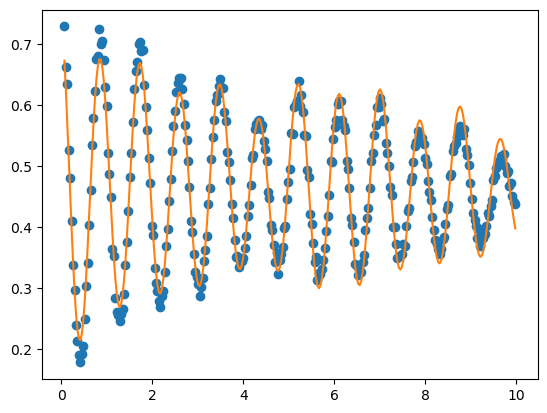

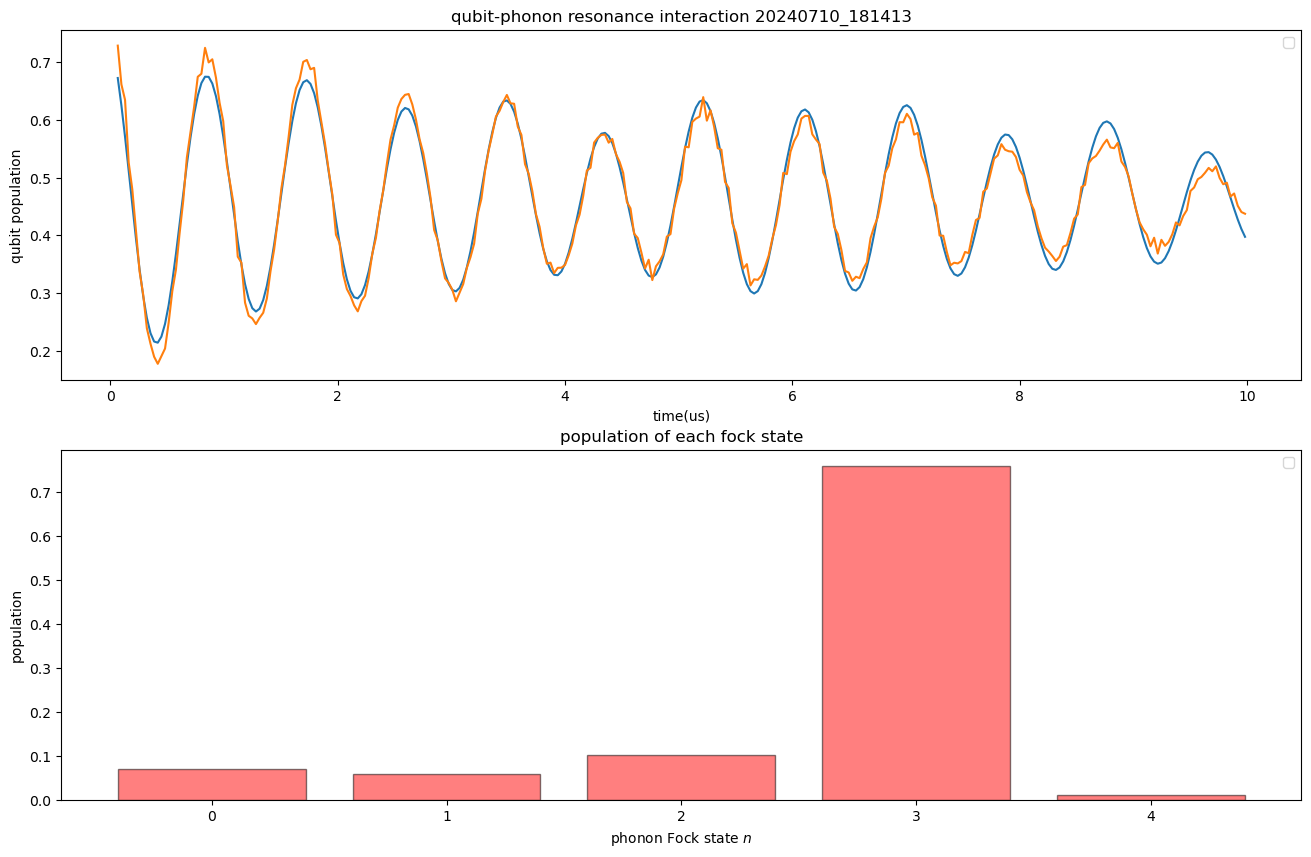

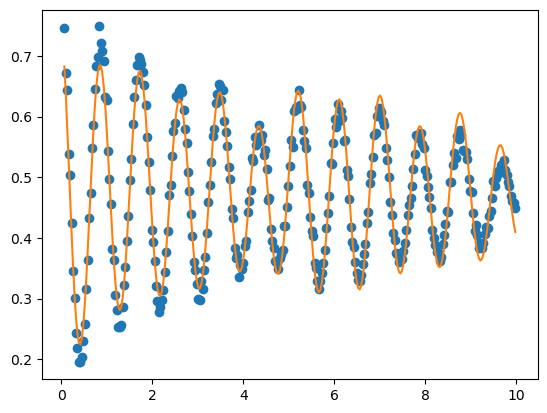

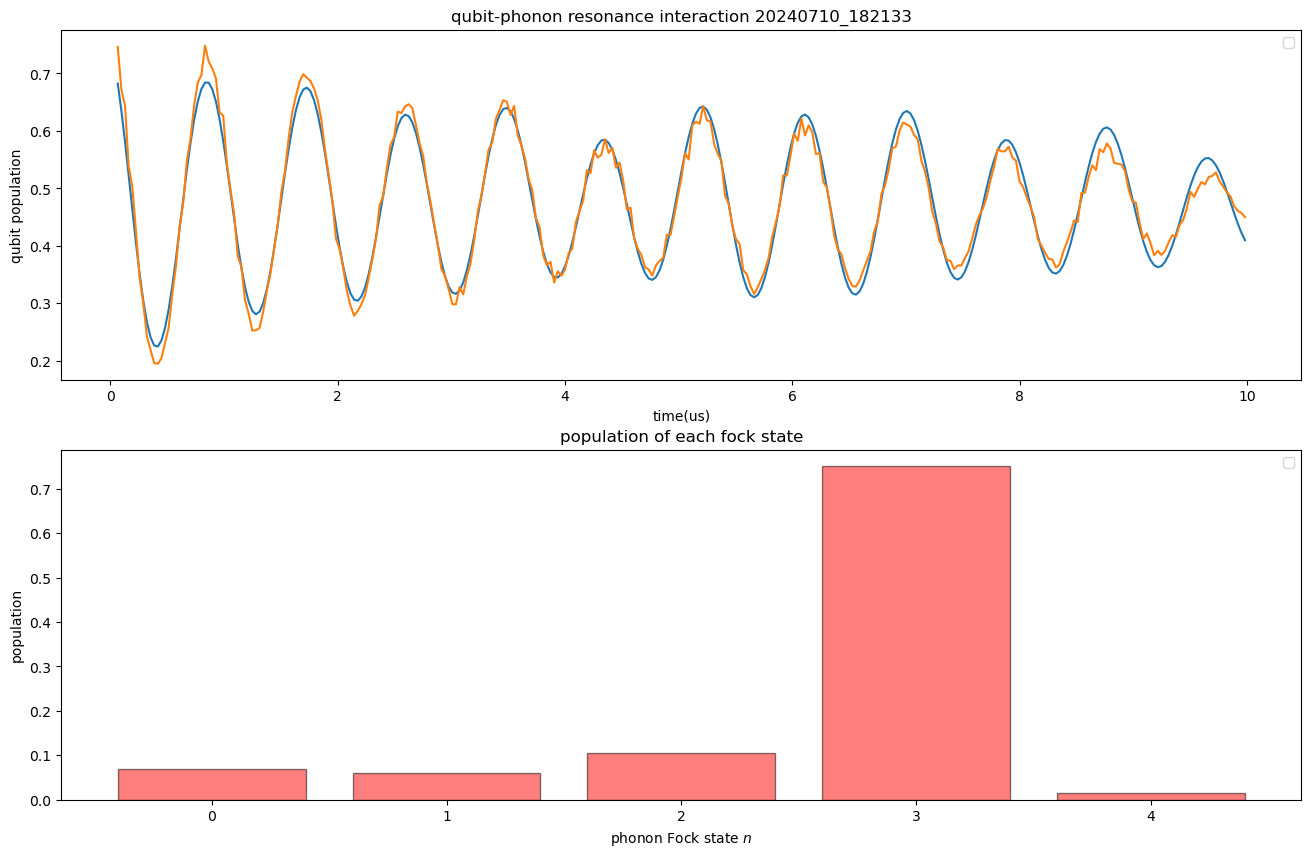

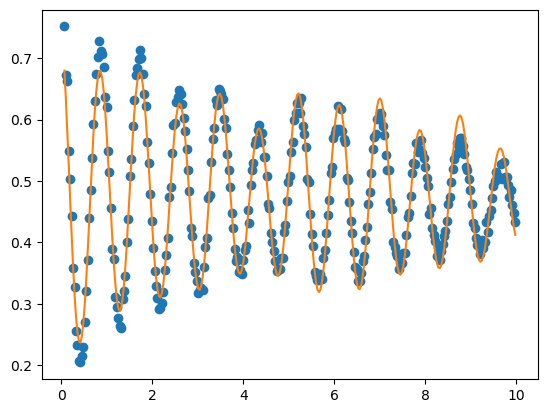

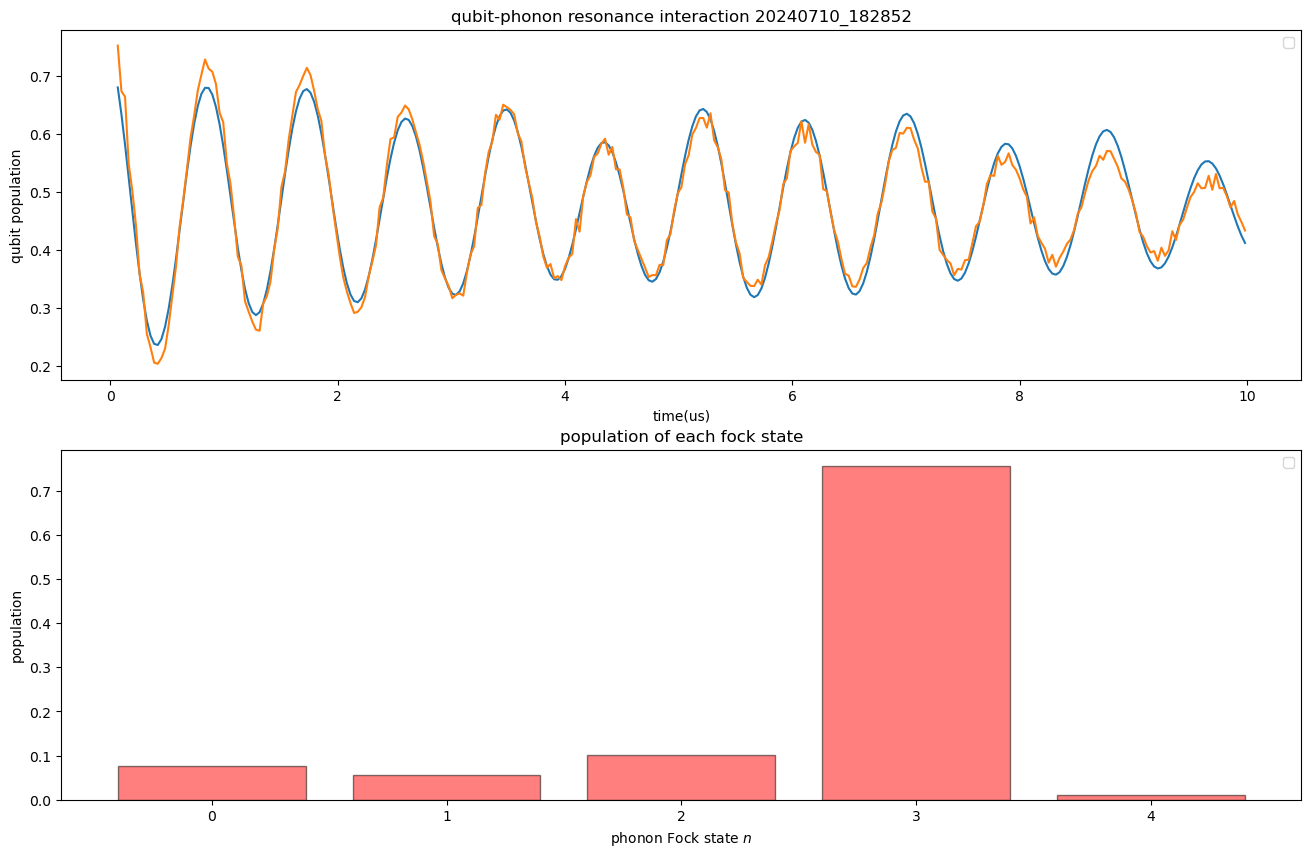

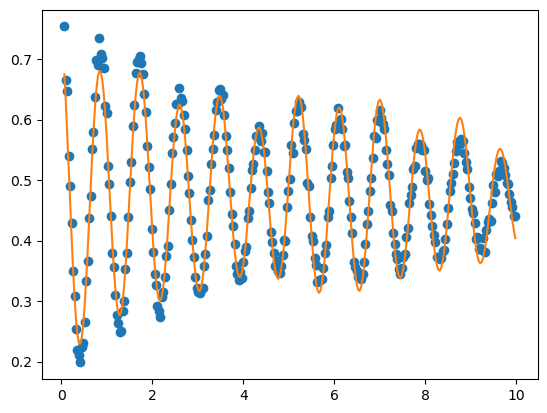

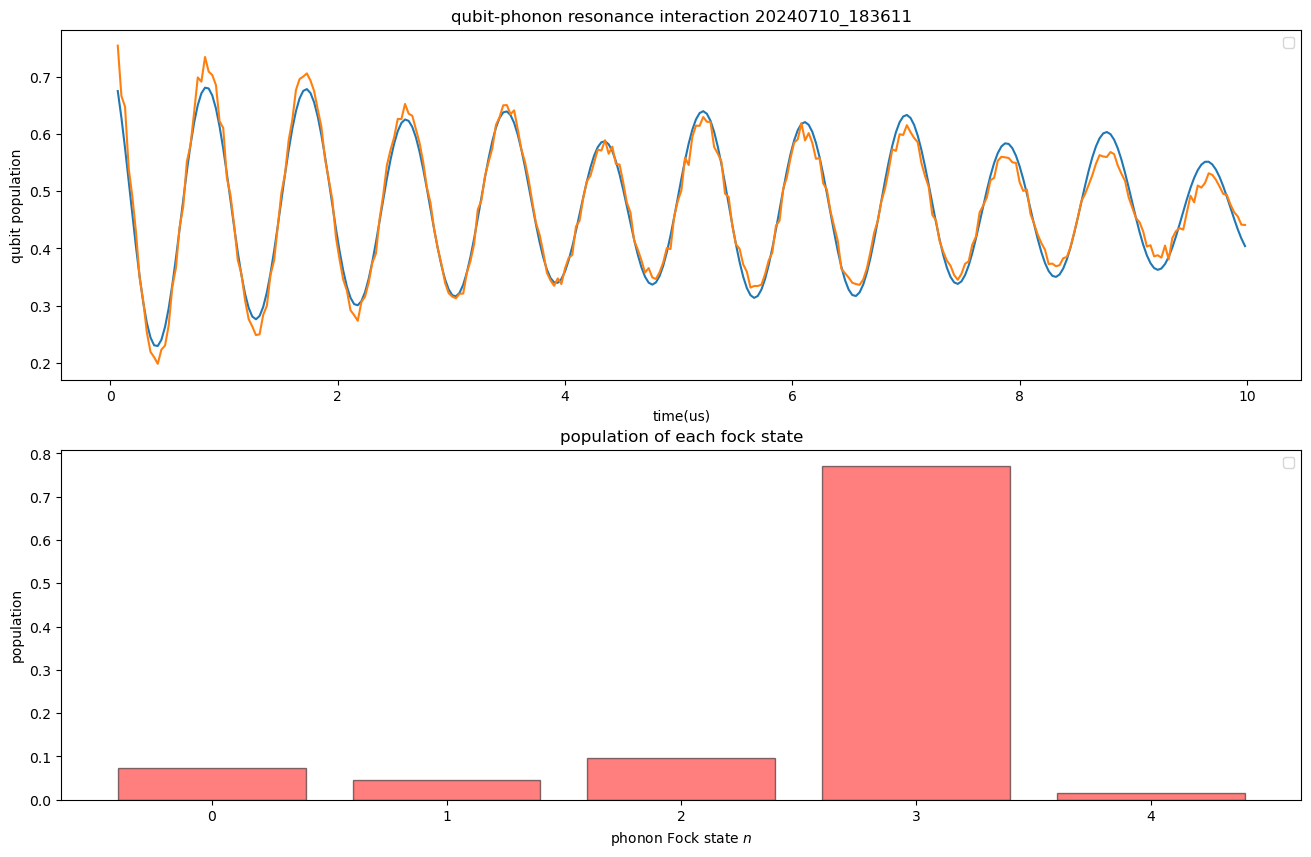

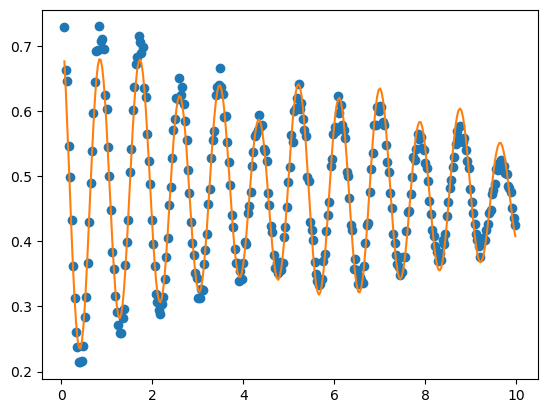

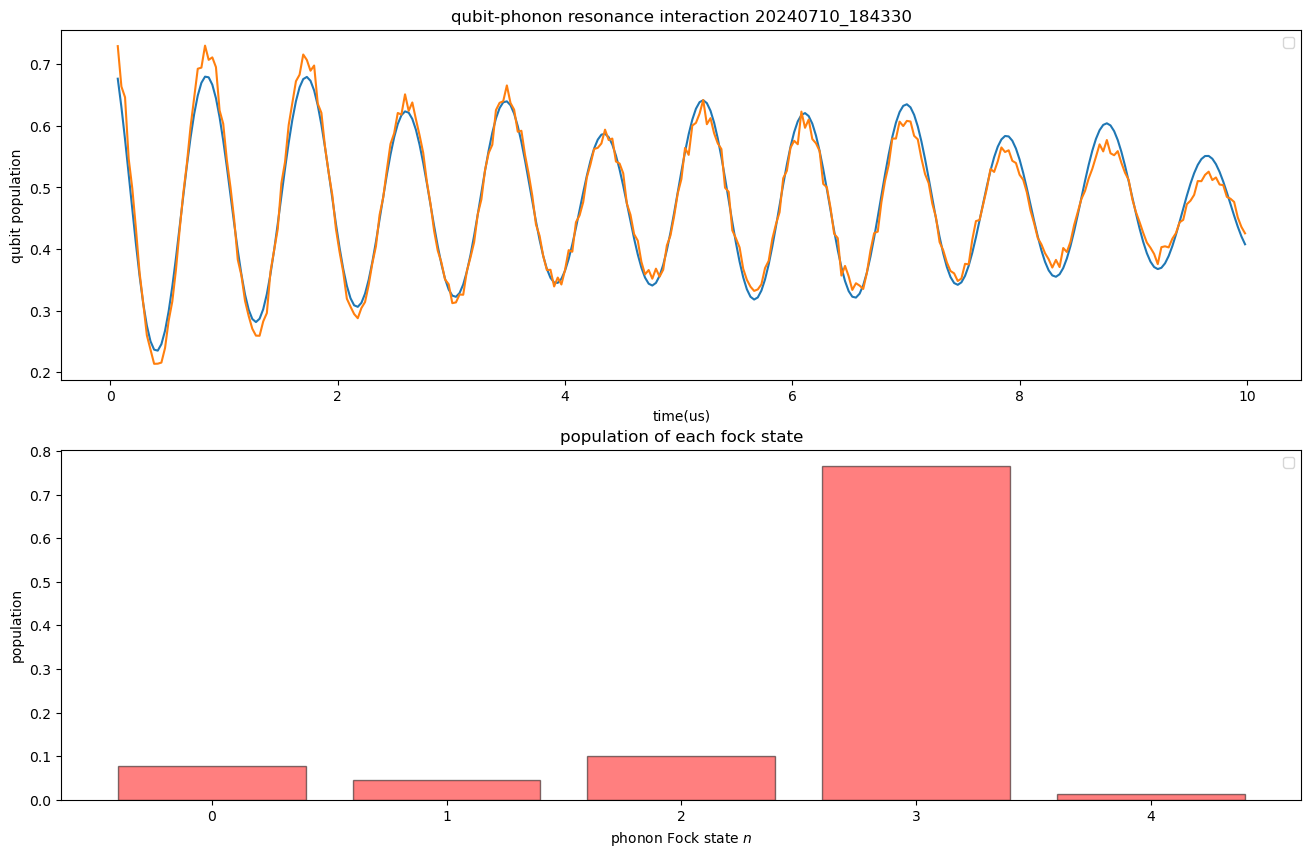

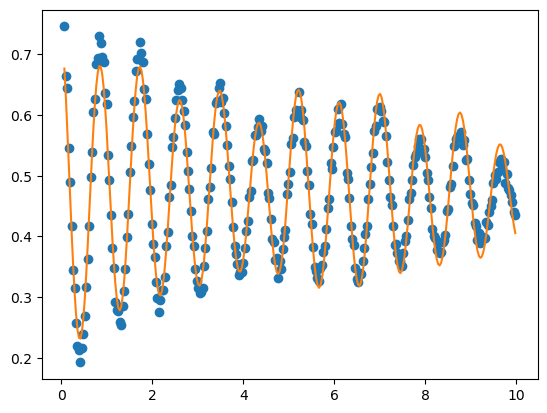

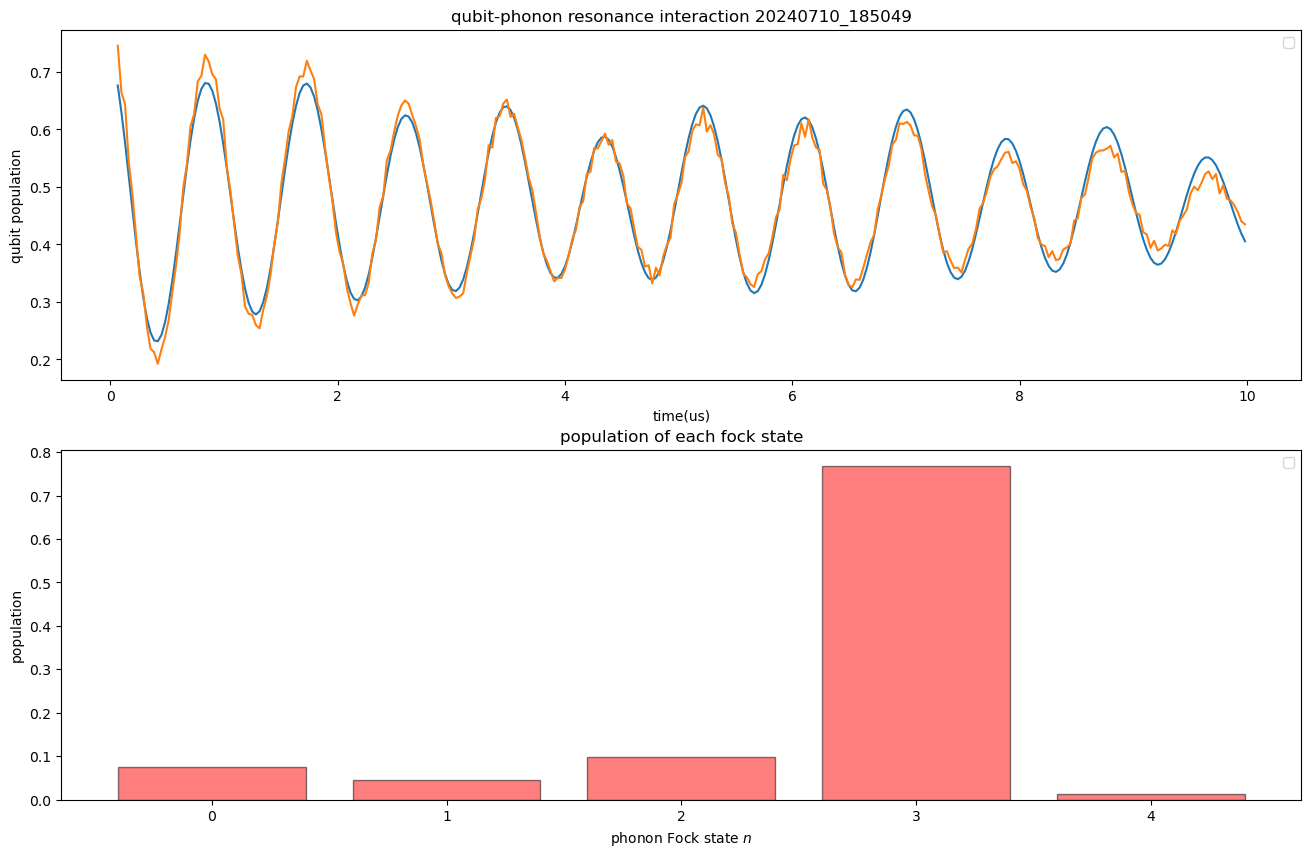

In [4]:
file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)

alphas_loose_ab = []
alpha_errs = []
a_list = []
b_list = []
loose_ab_se_values = []

for file_name in file_name_list:
    data = read_1D_data(file_name)
    data = truncate_data(data, max_time=maxtime)
    a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, measurement_time, g, T1q, T2q, T1p)
    initial_guess = [0] * (target_basis) 
    initial_guess[target_fock] = 1   
    output = plot_fitting(data[0], data[1], file_name, a, b, phonon_dim=target_basis, initial_guess=initial_guess)
    loose_ab_se_values.append(output[5])
    a_list.append(output[-3])
    b_list.append(output[-2])
    alphas_loose_ab.append(output[0])
    alpha_errs.append(output[1])

### Plot Histogram Colormap

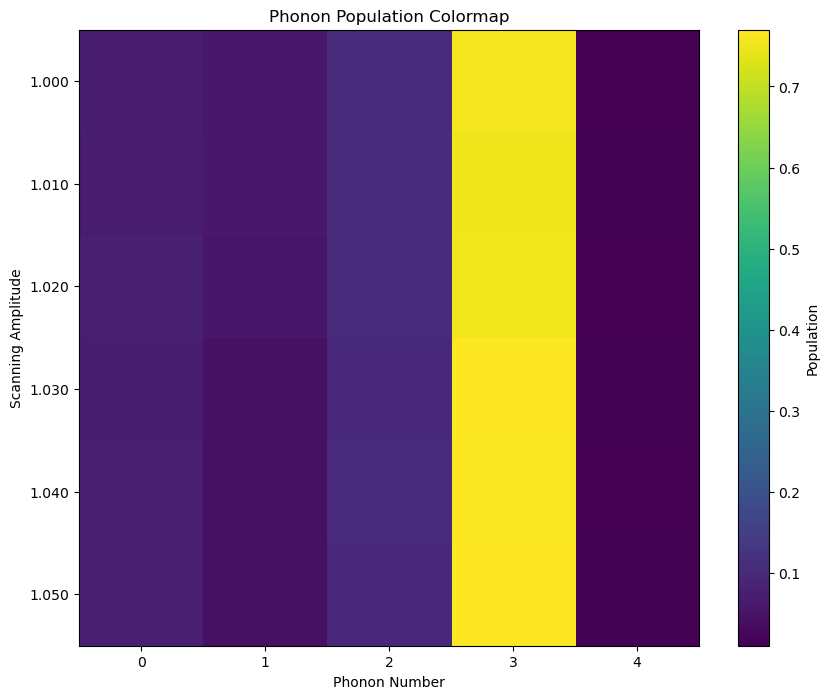

In [5]:
def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def plot_fitting(x_data, target_data, file_name, a, b, basis_list, phonon_dim=target_basis, initial_guess=None):
    fitted_basis = basis_list[:phonon_dim]
    bounds = [(0, 1)] * phonon_dim + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * phonon_dim + [0] + [0]), 1, 1)
    target_data = target_data

    if initial_guess is None:
        x0 = [0] * phonon_dim + [0] + [0]
    else:
        x0 = initial_guess + [0, 0]

    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    se_value = square_sum(result.x, target_data, fitted_basis)
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]
    
    y_pred = a * np.dot(fitted_population, fitted_basis) + b

    r_squared = calculate_r_squared(target_data, y_pred)

    return fitted_population, se_value, a, b, r_squared

file_name_list = get_datasets_between_timestamps(h5filename, start_time, end_time)
population_list = []
fit_results = []

for file_name in file_name_list:
    data = read_1D_data(file_name)
    data = truncate_data(data, max_time=maxtime)
    a, b, basis_list = fit_qubit_phonon_interaction_normalization(data, measurement_time, g, T1q, T2q, T1p)
    initial_guess = [0] * (target_basis) 
    initial_guess[target_fock] = 1   
    fitted_population, se_value, a, b, r_squared = plot_fitting(data[0], data[1], file_name, a, b, basis_list, phonon_dim=target_basis, initial_guess=initial_guess)
    population_list.append(fitted_population)
    fit_results.append((data[0], data[1], fitted_population, a, b, basis_list[:target_basis], file_name, r_squared))

population_array = np.array(population_list)

y_labels = amps
formatted_y_labels = [f'{label:.3f}' for label in y_labels]

num_labels = len(y_labels) // 1 # Dynamically choose the number of y labels
evenly_spaced_indices = np.round(np.linspace(0, len(formatted_y_labels) - 1, num_labels)).astype(int)
selected_y_labels = [formatted_y_labels[i] for i in evenly_spaced_indices]

plt.figure(figsize=(10, 8))
plt.imshow(population_array, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Population')
plt.xlabel('Phonon Number')
plt.ylabel('Scanning Amplitude')
plt.yticks(evenly_spaced_indices, selected_y_labels)
plt.title('Phonon Population Colormap')
plt.show()

### Plot the Fit and Histogram With Highest Fidelity

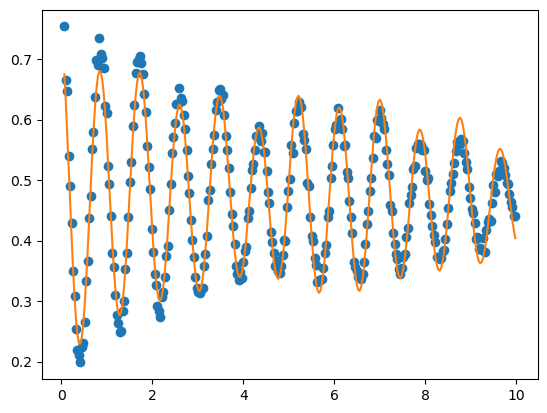

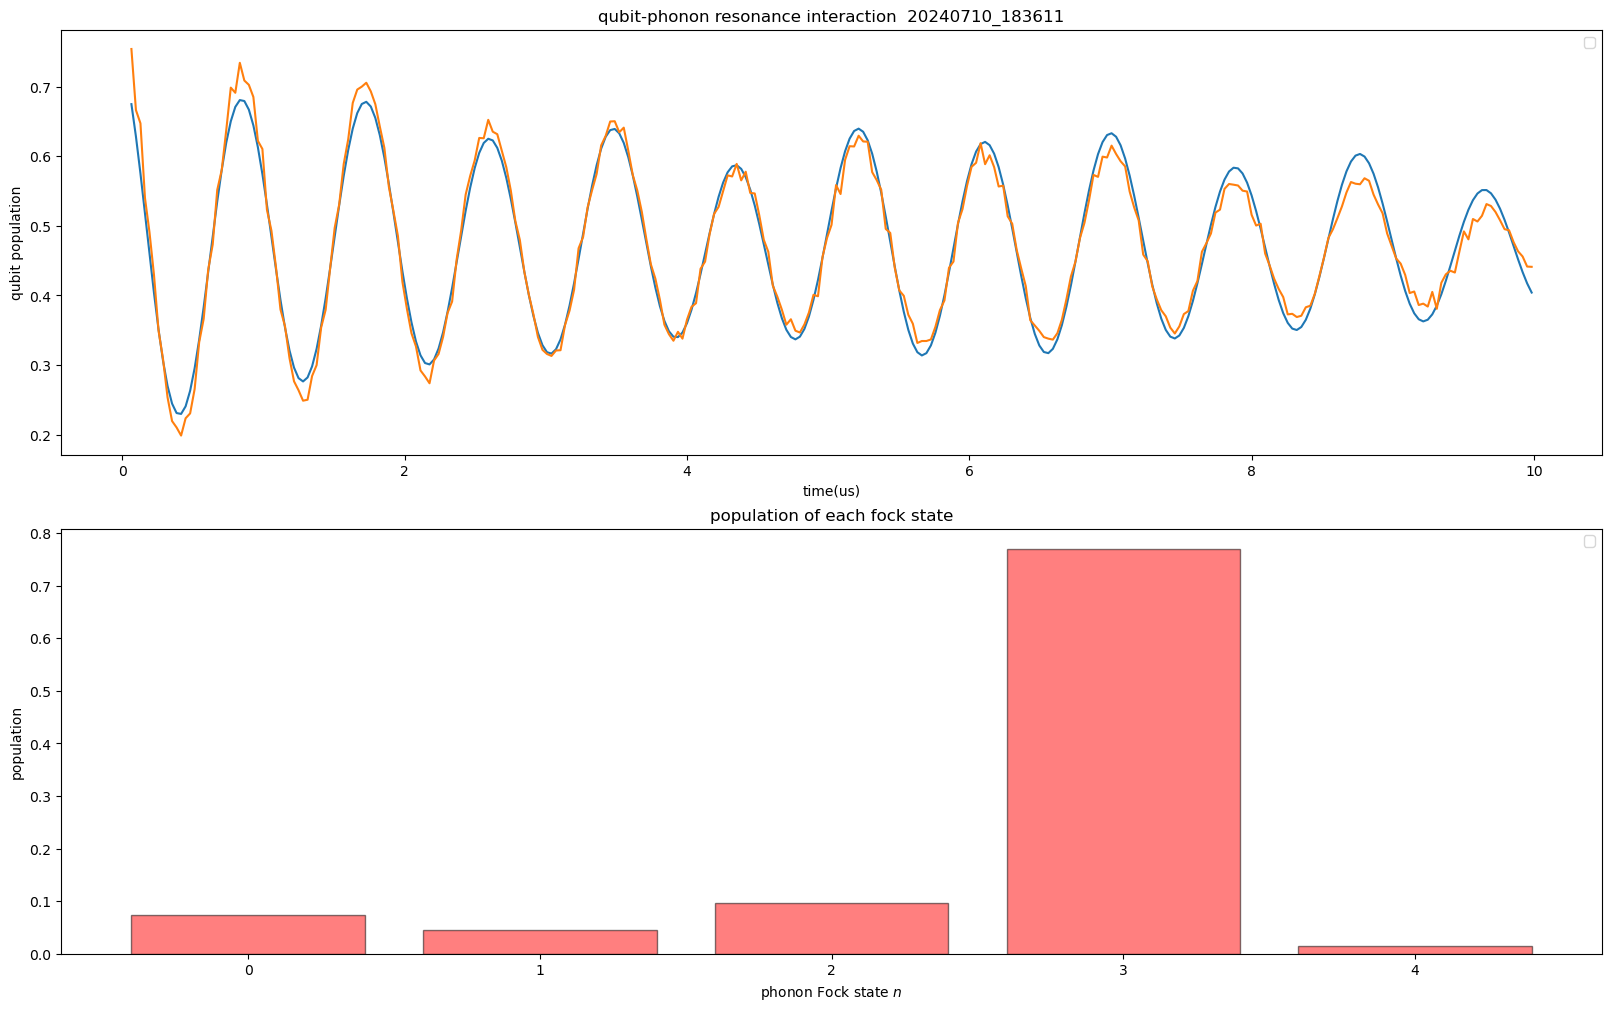

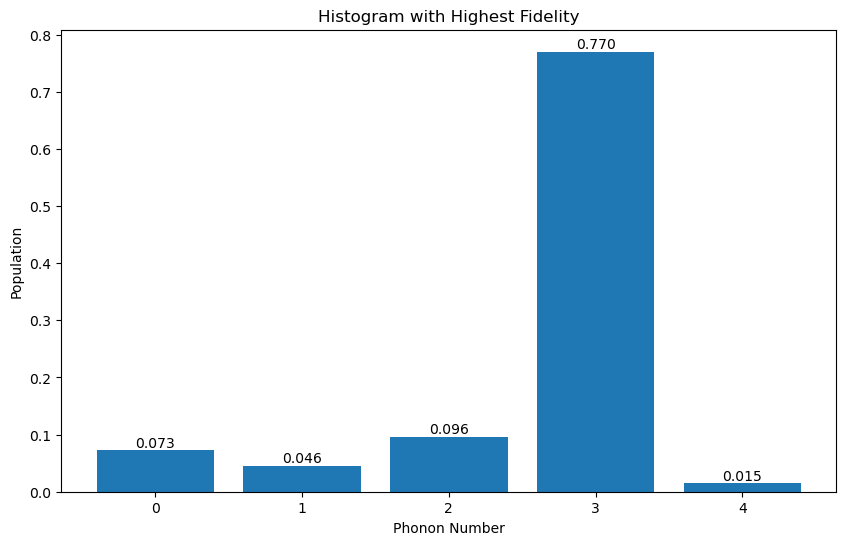

Amplitude : 1.03
R-squared statistic : 0.9723871735920723
Fidelity : 0.8774919523340293


In [6]:
max_fidelity_index = np.argmax(population_array[:, target_fock])
max_fit_result = fit_results[max_fidelity_index]
x_data_max, target_data_max, fitted_population_max, a_max, b_max, basis_list_max, file_name_max, r_squared_max = max_fit_result

plt.figure()
plt.plot(x_data_max, target_data_max, 'o', label='data')
plt.plot(x_data_max, a_max * np.dot(fitted_population_max, basis_list_max) + b_max, label='fit')
figure, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [1, 1]}, constrained_layout=True)
ax1.set_xlabel('time(us)')
ax1.set_ylabel('qubit population')
ax1.legend()
label = range(len(fitted_population_max))
ax2.set_xlabel(r'phonon Fock state $n$')
ax2.set_ylabel('population')
ax2.legend()
ax1.plot(x_data_max, a_max * np.dot(fitted_population_max, basis_list_max) + b_max, label='fitted')
ax1.plot(x_data_max, target_data_max, label='experiment')
ax2.bar(label, fitted_population_max, alpha=0.5, color='r', edgecolor='black', label='fitted from experiment')
ax1.set_title('qubit-phonon resonance interaction  ' + file_name_max)
ax2.set_title('population of each fock state')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(len(population_array[max_fidelity_index])), population_array[max_fidelity_index])
plt.xlabel('Phonon Number')
plt.ylabel('Population')
plt.title(f'Histogram with Highest Fidelity')

for i in range(target_basis):
    plt.text(i, population_array[max_fidelity_index][i], f'{population_array[max_fidelity_index][i]:.3f}', ha='center', va='bottom')
plt.show()

result = max_fit_result 
fitted_population = result[2]  
file_name = result[6]  
truncated_population = fitted_population[:20]
num_fock_states = len(truncated_population)
initial_state = sum(np.sqrt(pop) * qt.basis(num_fock_states, n) for n, pop in enumerate(truncated_population))
initial_state = initial_state.unit()
target = qt.fock(target_basis, target_fock)

print(f"Amplitude : {y_labels[max_fidelity_index]}")
print(f"R-squared statistic : {r_squared_max}")
print(f"Fidelity : {qt.fidelity(initial_state, target)}")

### Monte Carlo Error Bar

Population:
|0> : 0.0731047143 ± 0.0005395389
|1> : 0.0455517140 ± 0.0027578721
|2> : 0.0959617900 ± 0.0202715527
|3> : 0.7699921264 ± 0.0111127266
|4> : 0.0153896552 ± 0.0120261884


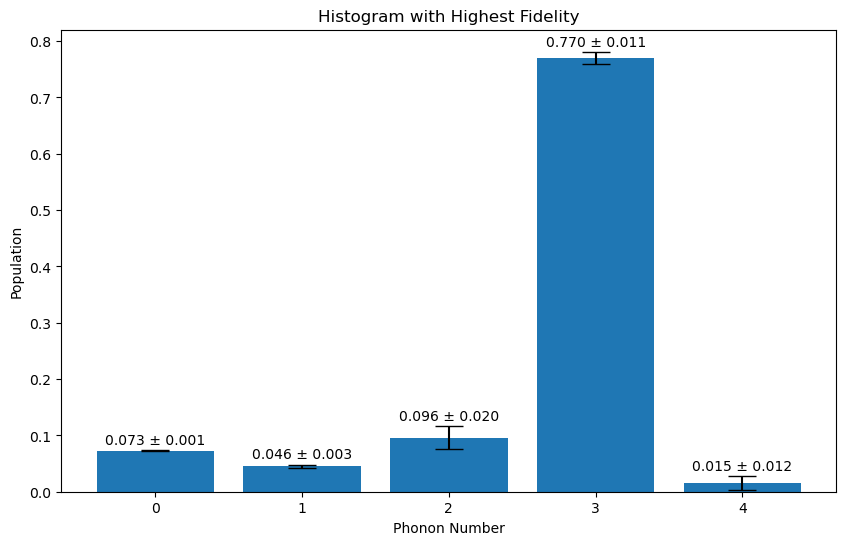

In [7]:
def perform_fit(x_data, target_data, a, b, basis_list, phonon_dim):
    fitted_basis = basis_list[:phonon_dim]
    bounds = [(0, 1)] * phonon_dim + [(None, None), (None, None)]
    const = LinearConstraint(np.array([1] * phonon_dim + [0] + [0]), 1, 1)
    x0 = [0] * phonon_dim + [0] + [0]
    result = minimize(square_sum, x0=x0, bounds=bounds, constraints=const, args=(target_data, fitted_basis))
    fitted_population = result.x[:-2] / np.sum(result.x[:-2])
    a = result.x[-2]
    b = result.x[-1]
    y_pred = a * np.dot(fitted_population, fitted_basis) + b
    r_squared = calculate_r_squared(target_data, y_pred)
    return fitted_population, r_squared

a_variation = 0.01
b_variation = 0.01
g_variation = 0.003
T1_variation = 0.48
T2_variation = 0.20
T1_phonon_varation = 4
num_variations = 100

populations_variations = []

for i in range(num_variations):
    a_varied = a_max + np.random.uniform(-a_variation, a_variation)
    b_varied = b_max + np.random.uniform(-b_variation, b_variation)
    g_varied = g + np.random.uniform(-g_variation, g_variation)
    T1_q_varied = T1q + np.random.uniform(-T1_variation, T1_variation)
    T2_q_pure_varied = T2q + np.random.uniform(-T2_variation, T2_variation)
    T1_p_varied = T1p + np.random.uniform(-T1_phonon_varation, T1_phonon_varation)
    _, _, basis_list_varied = fit_qubit_phonon_interaction_normalization(data, measurement_time, g_varied, T1_q_varied, T2_q_pure_varied, T1_p_varied)
    fitted_population_varied, _ = perform_fit(x_data_max, target_data_max, a_varied, b_varied, basis_list_varied, target_basis)
    populations_variations.append(fitted_population_varied)

populations_variations = np.array(populations_variations)
populations_std = np.std(populations_variations, axis=0)
populations_mean = population_array[max_fidelity_index]

print("Population:")
for i, (mean, std) in enumerate(zip(populations_mean, populations_std)):
    print(f"|{i}> : {mean:.10f} ± {std:.10f}")

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(populations_mean)), populations_mean, yerr=populations_std, capsize=10)
plt.xlabel('Phonon Number')
plt.ylabel('Population')
plt.title(f'Histogram with Highest Fidelity')

for bar, mean, std in zip(bars, populations_mean, populations_std):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + std + 0.005, f'{mean:.3f} ± {std:.3f}', ha='center', va='bottom', fontsize=10)

plt.show()